In [69]:

from sklearn.model_selection import train_test_split


In [70]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
import pandas as pd

class CustomOrdinalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, mapping=None):
        # Default mapping if none is provided.
        if mapping is None:
            mapping = {'Non-Travel': 0, 'Travel_Rarely': 1, 'Travel_Frequently': 2}
        self.mapping = mapping
        
    def fit(self, X, y=None):
        # Optionally, you could store the unique categories here.
        # For now, simply mark the encoder as fitted.
        self.fitted_ = True
        return self
    
    def transform(self, X):
        # Ensure the transformer has been fitted.
        if not hasattr(self, 'fitted_'):
            raise ValueError("This CustomOrdinalEncoder instance is not fitted yet. Call 'fit' before using this method.")
        
        # If X is a numpy array and has shape (n_samples, 1), flatten it.
        if isinstance(X, np.ndarray):
            if X.ndim == 2 and X.shape[1] == 1:
                s = pd.Series(X.ravel())
                mapped = s.map(self.mapping)
                if mapped.isnull().any():
                    raise ValueError("Some values were not found in the mapping")
                return mapped.values.reshape(-1, 1)
            else:
                raise ValueError("Expected a 2D array with a single column")
        else:
            # If X is a pandas DataFrame or Series.
            if isinstance(X, pd.DataFrame):
                if X.shape[1] == 1:
                    s = X.iloc[:, 0]
                    mapped = s.map(self.mapping)
                    if mapped.isnull().any():
                        raise ValueError("Some values were not found in the mapping")
                    return mapped.values.reshape(-1, 1)
                else:
                    # If there are multiple columns, apply mapping on each.
                    return X.apply(lambda col: col.map(self.mapping)).values
            elif isinstance(X, pd.Series):
                mapped = X.map(self.mapping)
                if mapped.isnull().any():
                    raise ValueError("Some values were not found in the mapping")
                return mapped.values.reshape(-1, 1)
            else:
                raise ValueError("Input type not recognized. Expected numpy array or pandas DataFrame/Series.")

In [71]:

df = pd.read_csv("WA_Fn-UseC_-HR-Employee-Attrition.csv")
df.drop(columns=['EmployeeCount', 'StandardHours', 'EmployeeNumber'], inplace=True)
df.drop_duplicates(inplace=True)

# Convert Attrition to binary: 'Yes' → 1, 'No' → 0.
df["Attrition"] = df["Attrition"].map({'Yes': 1, 'No': 0})

X = df.drop("Attrition", axis=1)
y = df["Attrition"]

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
# Reset indices to ensure alignment
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test  = X_test.reset_index(drop=True)
y_test  = y_test.reset_index(drop=True)

In [72]:
import os
import joblib
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    ConfusionMatrixDisplay,
    roc_curve, auc,
    fbeta_score
)

def display_model_details(model_file, X_train, y_train, X_test, y_test):
    """
    Loads a model from the given file, then displays:
      - The pipeline parameters (preprocessing and classifier settings)
      - Classification reports for both the training and test sets
      - Confusion matrices for both the training and test sets using ConfusionMatrixDisplay
      - ROC curves (if available) for both the training and test sets using built-in display functions,
        including a diagonal "no skill" line.
      - Overall accuracy and F2 scores for train and test sets.
    
    Parameters:
    - model_file: str, path to the saved model (e.g., a .joblib file)
    - X_train, y_train: Training data.
    - X_test, y_test: Test data.
    """
    # Load the model
    model = joblib.load(model_file)
    model_name = os.path.splitext(os.path.basename(model_file))[0]
    
    # Display model name and pipeline parameters.
    display(Markdown(f"## Model: {model_name}"))
    params = model.get_params()
    md_params = f"""### Pipeline Parameters for **{model_name}**:
- **preprocessor__num__log:** {params.get('preprocessor__num__log')}
- **preprocessor__num__scaler:** {params.get('preprocessor__num__scaler')}
- **preprocessor__bus__encoder:** {params.get('preprocessor__bus__encoder')}
- **feat_sel:** {params.get('feat_sel')}
- **classifier:** {params.get('classifier')}
"""
    display(Markdown(md_params))
    
    def display_performance(X, y, dataset_name="Test Set"):
        y_pred = model.predict(X)
        report = classification_report(y, y_pred)
        acc = accuracy_score(y, y_pred)
        # Compute F2 score using beta=2
        f2 = fbeta_score(y, y_pred, beta=2, zero_division=0)
        
        display(Markdown(f"### {dataset_name} Set Classification Report for **{model_name}**"))
        display(Markdown(f"```\n{report}\n```"))
        display(Markdown(f"**{dataset_name} Accuracy for {model_name}:** {acc:.4f}"))
        display(Markdown(f"**{dataset_name} F2 Score for {model_name}:** {f2:.4f}"))
        
        # Plot confusion matrix using ConfusionMatrixDisplay
        disp = ConfusionMatrixDisplay.from_predictions(y, y_pred, cmap=plt.cm.Blues)
        disp.ax_.set_title(f"Confusion Matrix ({dataset_name}) for {model_name}")
        plt.show()
        
        # Plot ROC curve using roc_curve and auc, including the diagonal line.
        if hasattr(model, "predict_proba"):
            y_prob = model.predict_proba(X)[:, 1]
            fpr, tpr, thresholds = roc_curve(y, y_prob)
            model_auc = auc(fpr, tpr)
            plt.figure(figsize=(5,4))
            plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {model_auc:.2f})")
            plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", label="No Skill (AUC = 0.5)")
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title(f"ROC Curve ({dataset_name}) for {model_name}")
            plt.legend(loc="lower right")
            plt.show()
        else:
            display(Markdown(f"Model does not support predict_proba; skipping ROC curve for {dataset_name} for {model_name}."))
    
    # Display performance on training data.
    display(Markdown("### Training Set Performance"))
    display_performance(X_train, y_train, dataset_name="Training Set")
    
    # Display performance on test data.
    display(Markdown("### Test Set Performance"))
    display_performance(X_test, y_test, dataset_name="Test Set")




## Model: LogisticRegression_tuned_model

### Pipeline Parameters for **LogisticRegression_tuned_model**:
- **preprocessor__num__log:** FunctionTransformer(func=<ufunc 'log1p'>, validate=True)
- **preprocessor__num__scaler:** MinMaxScaler()
- **preprocessor__bus__encoder:** CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1})
- **feat_sel:** SelectFromModel(estimator=LogisticRegression(penalty='l1', random_state=42,
                                             solver='liblinear'))
- **classifier:** LogisticRegression(C=1, max_iter=500, random_state=42, solver='saga')


### Training Set Performance

### Training Set Set Classification Report for **LogisticRegression_tuned_model**

```
              precision    recall  f1-score   support

           0       0.95      0.81      0.87       986
           1       0.44      0.77      0.56       190

    accuracy                           0.80      1176
   macro avg       0.69      0.79      0.71      1176
weighted avg       0.86      0.80      0.82      1176

```

**Training Set Accuracy for LogisticRegression_tuned_model:** 0.8019

**Training Set F2 Score for LogisticRegression_tuned_model:** 0.6667

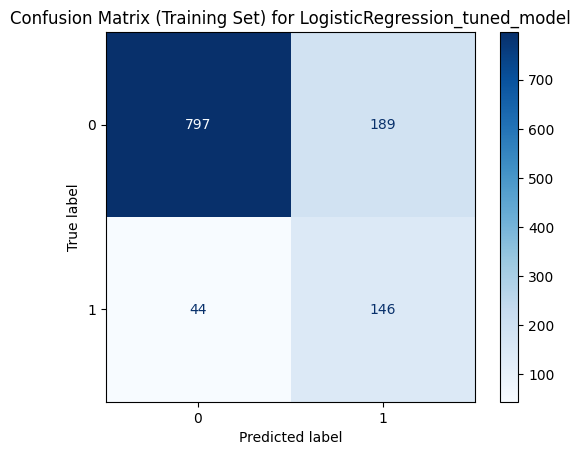

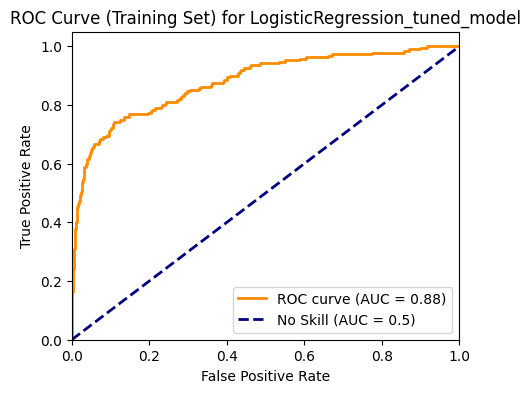

### Test Set Performance

### Test Set Set Classification Report for **LogisticRegression_tuned_model**

```
              precision    recall  f1-score   support

           0       0.93      0.83      0.88       247
           1       0.43      0.68      0.53        47

    accuracy                           0.81       294
   macro avg       0.68      0.76      0.70       294
weighted avg       0.85      0.81      0.82       294

```

**Test Set Accuracy for LogisticRegression_tuned_model:** 0.8061

**Test Set F2 Score for LogisticRegression_tuned_model:** 0.6107

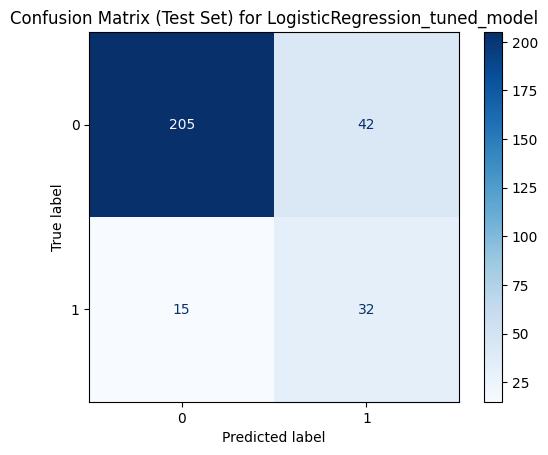

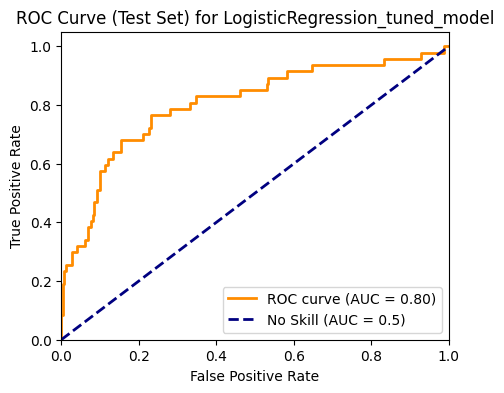

In [73]:
model_file = "models/LogisticRegression_tuned_model.joblib" 
display_model_details(model_file,X_train, y_train, X_test, y_test)

## Model: DecisionTree_tuned_model

### Pipeline Parameters for **DecisionTree_tuned_model**:
- **preprocessor__num__log:** FunctionTransformer(func=<ufunc 'log1p'>, validate=True)
- **preprocessor__num__scaler:** MinMaxScaler()
- **preprocessor__bus__encoder:** CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1})
- **feat_sel:** SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                threshold='median')
- **classifier:** DecisionTreeClassifier(min_samples_leaf=2, min_samples_split=10,
                       random_state=42)


### Training Set Performance

### Training Set Set Classification Report for **DecisionTree_tuned_model**

```
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       986
           1       0.88      0.72      0.79       190

    accuracy                           0.94      1176
   macro avg       0.91      0.85      0.88      1176
weighted avg       0.94      0.94      0.94      1176

```

**Training Set Accuracy for DecisionTree_tuned_model:** 0.9379

**Training Set F2 Score for DecisionTree_tuned_model:** 0.7432

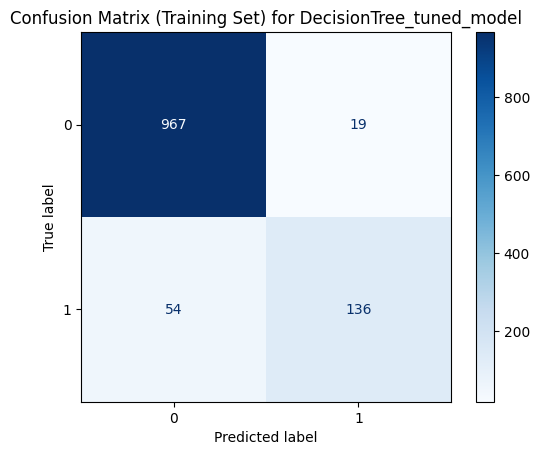

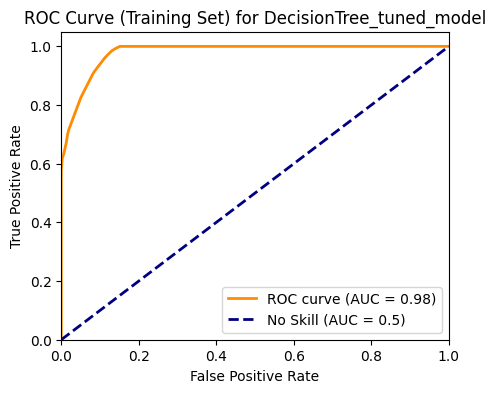

### Test Set Performance

### Test Set Set Classification Report for **DecisionTree_tuned_model**

```
              precision    recall  f1-score   support

           0       0.87      0.87      0.87       247
           1       0.34      0.34      0.34        47

    accuracy                           0.79       294
   macro avg       0.61      0.61      0.61       294
weighted avg       0.79      0.79      0.79       294

```

**Test Set Accuracy for DecisionTree_tuned_model:** 0.7891

**Test Set F2 Score for DecisionTree_tuned_model:** 0.3404

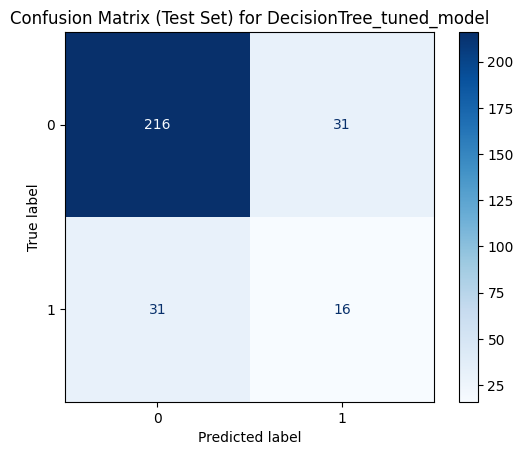

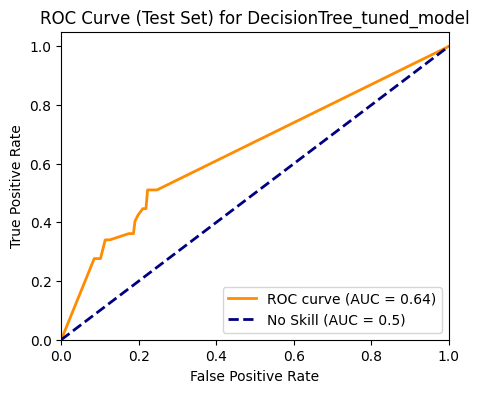

In [74]:
model_file = "models/DecisionTree_tuned_model.joblib" 
display_model_details(model_file, X_train, y_train,X_test, y_test)

## Model: RandomForest_tuned_model

### Pipeline Parameters for **RandomForest_tuned_model**:
- **preprocessor__num__log:** passthrough
- **preprocessor__num__scaler:** MinMaxScaler()
- **preprocessor__bus__encoder:** CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1})
- **feat_sel:** RFE(estimator=LogisticRegression(max_iter=500, random_state=42),
    n_features_to_select=10)
- **classifier:** RandomForestClassifier(max_depth=5, min_samples_leaf=2, min_samples_split=5,
                       random_state=42)


### Training Set Performance

### Training Set Set Classification Report for **RandomForest_tuned_model**

```
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       986
           1       0.50      0.56      0.53       190

    accuracy                           0.84      1176
   macro avg       0.71      0.73      0.72      1176
weighted avg       0.85      0.84      0.84      1176

```

**Training Set Accuracy for RandomForest_tuned_model:** 0.8401

**Training Set F2 Score for RandomForest_tuned_model:** 0.5504

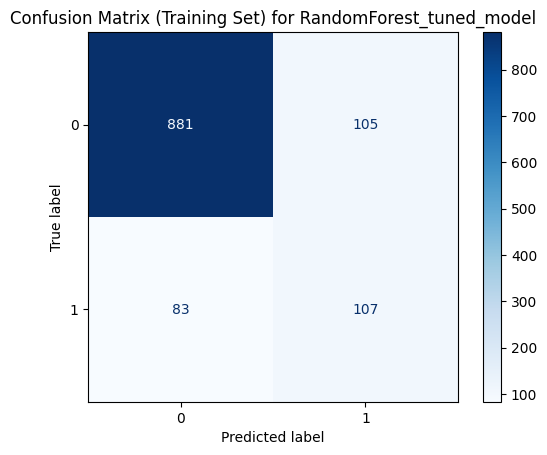

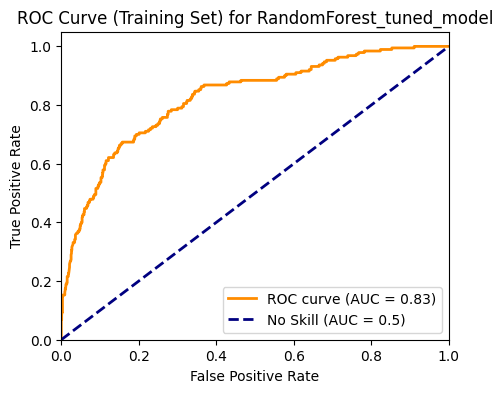

### Test Set Performance

### Test Set Set Classification Report for **RandomForest_tuned_model**

```
              precision    recall  f1-score   support

           0       0.90      0.82      0.86       247
           1       0.35      0.51      0.42        47

    accuracy                           0.77       294
   macro avg       0.63      0.67      0.64       294
weighted avg       0.81      0.77      0.79       294

```

**Test Set Accuracy for RandomForest_tuned_model:** 0.7721

**Test Set F2 Score for RandomForest_tuned_model:** 0.4688

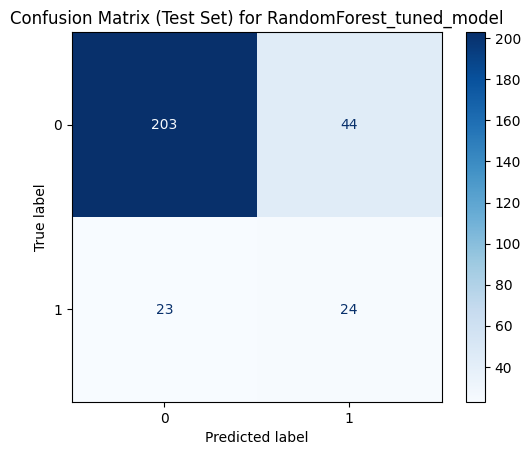

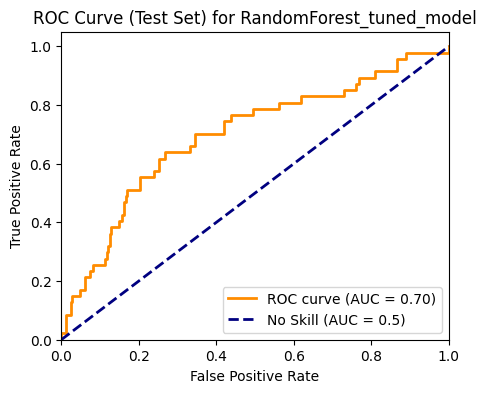

In [75]:
model_file = "models/RandomForest_tuned_model.joblib" 
display_model_details(model_file, X_train, y_train,X_test, y_test)

## Model: GradientBoosting_tuned_model

### Pipeline Parameters for **GradientBoosting_tuned_model**:
- **preprocessor__num__log:** FunctionTransformer(func=<ufunc 'log1p'>, validate=True)
- **preprocessor__num__scaler:** MinMaxScaler()
- **preprocessor__bus__encoder:** OneHotEncoder(drop='first')
- **feat_sel:** SelectFromModel(estimator=LogisticRegression(penalty='l1', random_state=42,
                                             solver='liblinear'))
- **classifier:** GradientBoostingClassifier(learning_rate=0.01, max_features='log2',
                           n_estimators=200, random_state=42)


### Training Set Performance

### Training Set Set Classification Report for **GradientBoosting_tuned_model**

```
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       986
           1       0.61      0.61      0.61       190

    accuracy                           0.88      1176
   macro avg       0.77      0.77      0.77      1176
weighted avg       0.87      0.88      0.87      1176

```

**Training Set Accuracy for GradientBoosting_tuned_model:** 0.8750

**Training Set F2 Score for GradientBoosting_tuned_model:** 0.6112

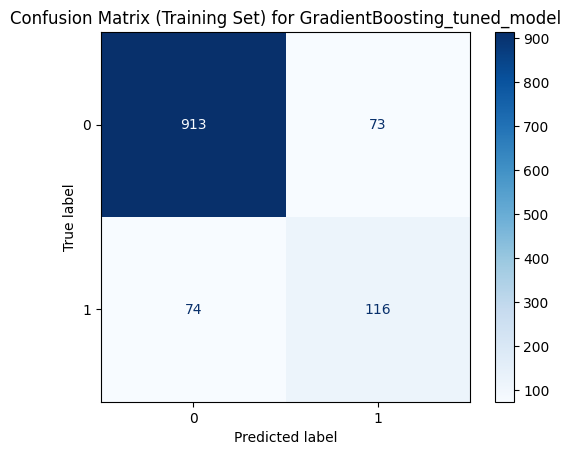

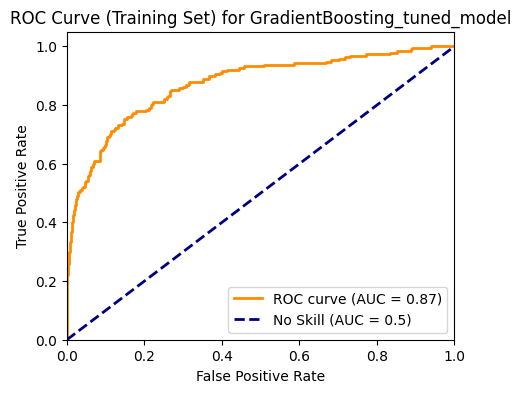

### Test Set Performance

### Test Set Set Classification Report for **GradientBoosting_tuned_model**

```
              precision    recall  f1-score   support

           0       0.88      0.87      0.88       247
           1       0.37      0.40      0.39        47

    accuracy                           0.80       294
   macro avg       0.63      0.64      0.63       294
weighted avg       0.80      0.80      0.80       294

```

**Test Set Accuracy for GradientBoosting_tuned_model:** 0.7959

**Test Set F2 Score for GradientBoosting_tuned_model:** 0.3975

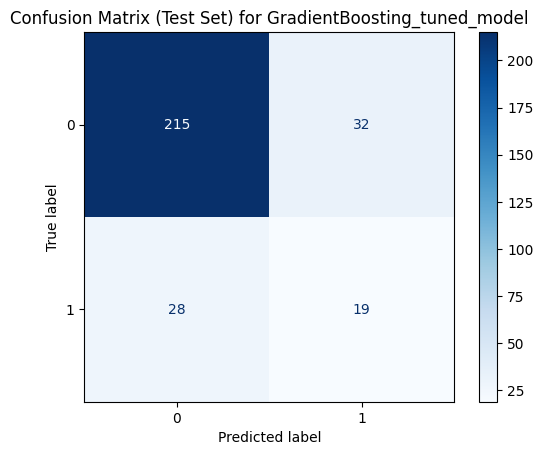

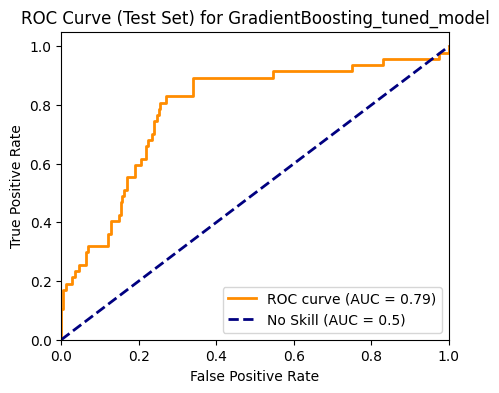

In [76]:
model_file = "models/GradientBoosting_tuned_model.joblib" 
display_model_details(model_file, X_train, y_train,X_test, y_test)

## Model: MLP_tuned_model

### Pipeline Parameters for **MLP_tuned_model**:
- **preprocessor__num__log:** FunctionTransformer(func=<ufunc 'log1p'>, validate=True)
- **preprocessor__num__scaler:** StandardScaler()
- **preprocessor__bus__encoder:** CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1})
- **feat_sel:** passthrough
- **classifier:** MLPClassifier(activation='tanh', hidden_layer_sizes=(50,), max_iter=500,
              random_state=42)


### Training Set Performance

### Training Set Set Classification Report for **MLP_tuned_model**

```
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       986
           1       1.00      1.00      1.00       190

    accuracy                           1.00      1176
   macro avg       1.00      1.00      1.00      1176
weighted avg       1.00      1.00      1.00      1176

```

**Training Set Accuracy for MLP_tuned_model:** 1.0000

**Training Set F2 Score for MLP_tuned_model:** 1.0000

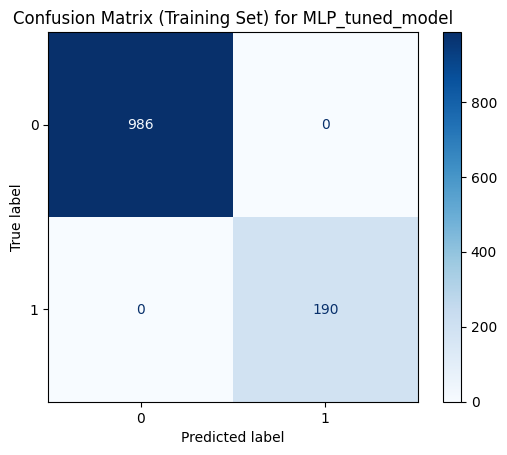

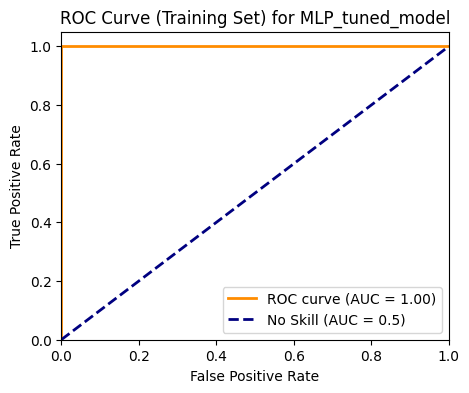

### Test Set Performance

### Test Set Set Classification Report for **MLP_tuned_model**

```
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       247
           1       0.53      0.49      0.51        47

    accuracy                           0.85       294
   macro avg       0.72      0.70      0.71       294
weighted avg       0.85      0.85      0.85       294

```

**Test Set Accuracy for MLP_tuned_model:** 0.8503

**Test Set F2 Score for MLP_tuned_model:** 0.4978

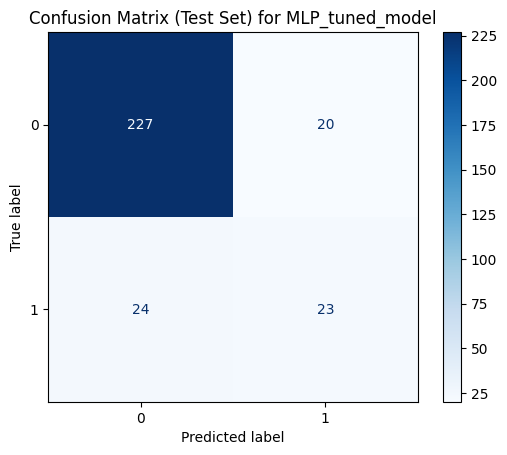

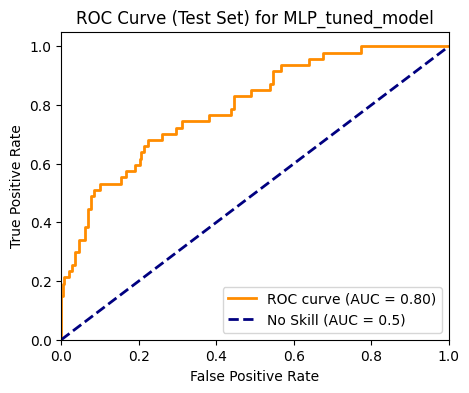

In [77]:
model_file = "models/MLP_tuned_model.joblib" 
display_model_details(model_file,X_train, y_train, X_test, y_test)

## Model: stacking_logistic_regression

### Pipeline Parameters for **stacking_logistic_regression**:
- **preprocessor__num__log:** None
- **preprocessor__num__scaler:** None
- **preprocessor__bus__encoder:** None
- **feat_sel:** None
- **classifier:** None


### Training Set Performance

### Training Set Set Classification Report for **stacking_logistic_regression**

```
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       986
           1       1.00      0.71      0.83       190

    accuracy                           0.95      1176
   macro avg       0.97      0.86      0.90      1176
weighted avg       0.96      0.95      0.95      1176

```

**Training Set Accuracy for stacking_logistic_regression:** 0.9532

**Training Set F2 Score for stacking_logistic_regression:** 0.7542

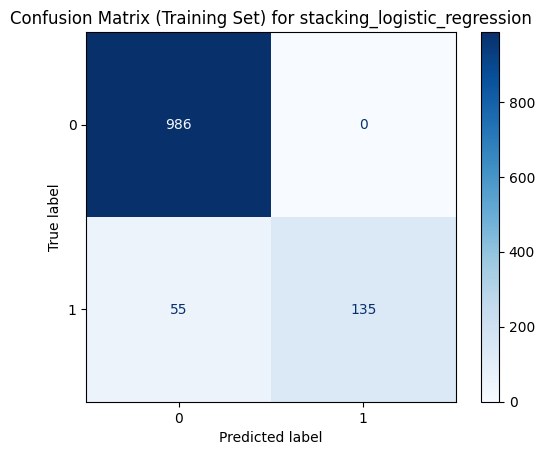

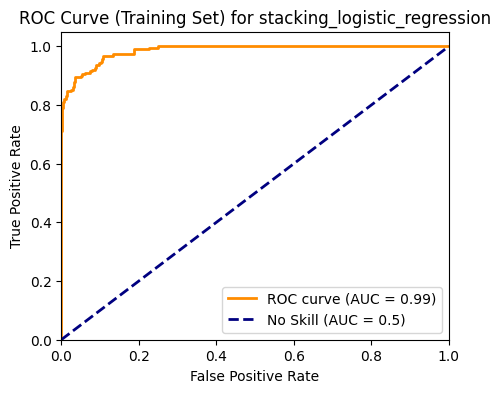

### Test Set Performance

### Test Set Set Classification Report for **stacking_logistic_regression**

```
              precision    recall  f1-score   support

           0       0.89      0.96      0.92       247
           1       0.64      0.38      0.48        47

    accuracy                           0.87       294
   macro avg       0.77      0.67      0.70       294
weighted avg       0.85      0.87      0.85       294

```

**Test Set Accuracy for stacking_logistic_regression:** 0.8673

**Test Set F2 Score for stacking_logistic_regression:** 0.4167

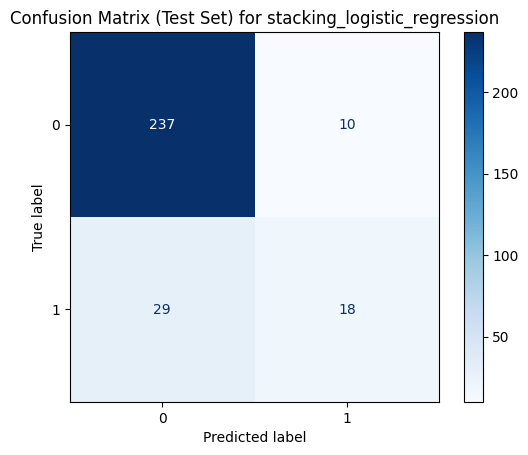

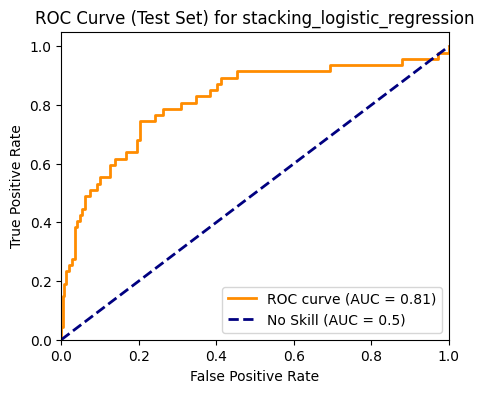

In [78]:
model_file = "models/stacking_logistic_regression.joblib" 
display_model_details(model_file,X_train, y_train, X_test, y_test)

## Model: stacking_decision_tree

### Pipeline Parameters for **stacking_decision_tree**:
- **preprocessor__num__log:** None
- **preprocessor__num__scaler:** None
- **preprocessor__bus__encoder:** None
- **feat_sel:** None
- **classifier:** None


### Training Set Performance

### Training Set Set Classification Report for **stacking_decision_tree**

```
              precision    recall  f1-score   support

           0       0.91      0.99      0.95       986
           1       0.92      0.49      0.64       190

    accuracy                           0.91      1176
   macro avg       0.92      0.74      0.80      1176
weighted avg       0.91      0.91      0.90      1176

```

**Training Set Accuracy for stacking_decision_tree:** 0.9116

**Training Set F2 Score for stacking_decision_tree:** 0.5452

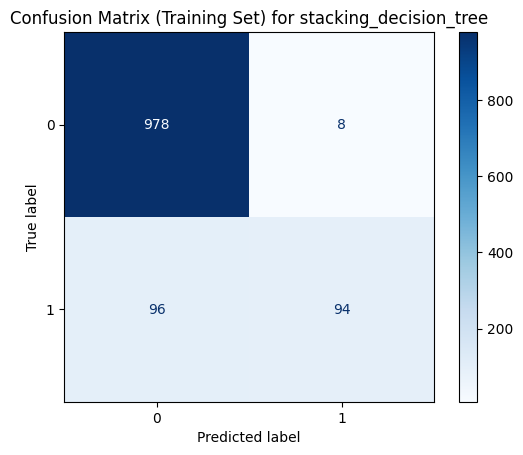

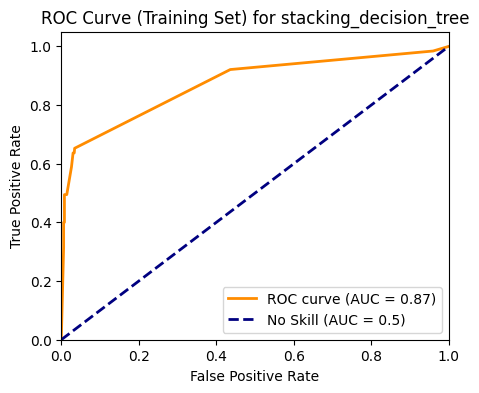

### Test Set Performance

### Test Set Set Classification Report for **stacking_decision_tree**

```
              precision    recall  f1-score   support

           0       0.87      0.98      0.92       247
           1       0.67      0.21      0.32        47

    accuracy                           0.86       294
   macro avg       0.77      0.60      0.62       294
weighted avg       0.84      0.86      0.82       294

```

**Test Set Accuracy for stacking_decision_tree:** 0.8571

**Test Set F2 Score for stacking_decision_tree:** 0.2463

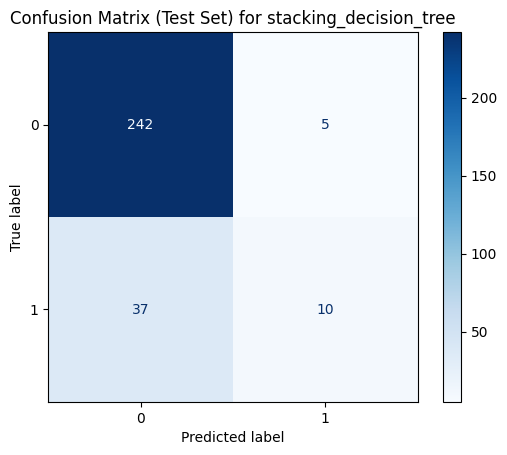

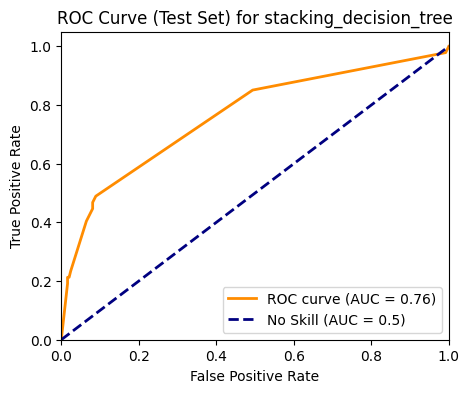

In [79]:
model_file = "models/stacking_decision_tree.joblib" 
display_model_details(model_file,X_train, y_train, X_test, y_test)